In [14]:
import numpy as np
import sympy as sm


The Problem
------------------
Assume a series of *n* different potentials, where $V(x) = V_0 \iff x<L_0; ~ V(x) = V_j \iff L_{j-1} < x < L_{j}; ~ V(x) = V_n \iff L_{n-1} < x$.

Assume a particle is incident from the left moving towards the right with incident energy $E$ and incident wave coefficient $F_0$. 

We want to find the different wavefunctions $\psi_j$ for the *n* different regions.

Initial Knowledge
-----------
We know that each section $j$ will have some proportion transmitted and some reflected, IE $\psi_j = F_je^{ik_jx} + R_je^{-ik_jx}$. 
Using the Schrodinger Equation $-\frac{\hbar^2}{2m}\psi_j + V_j\psi_j = E\psi_j$, we can also see that $k_j = \sqrt{\frac{2m(E - V_j)}{\hbar^2}}$.

Since wave equations must be continious and continiously differentiable, we know that $\psi_j(L_j) = \psi_{j+1}(L_j)$ and $\frac{\partial \psi_j}{\partial x}(L_j) = \frac{\partial \psi_{j+1}}{\partial x}(L_j)$.


Finding the Constraints
-------------
This quickly reduces to a system of linear equations of size $2n$, due to having $n$ separate regions containing 2 separate wave directions each.

For border $j \le n-1$, we get the system of equations:

$$\begin{align}
F_je^{ik_jL_j} + R_je^{-ik_jL_j} &= F_{j+1}e^{ik_{j+1}L_j} + R_{j+1}e^{-ik_{j+1}L_j} \\
ik_jF_je^{ik_jL_j} - ik_jR_je^{-ik_jL_j} &= ik_{j+1}F_{j+1}e^{ik_{j+1}L_j} - ik_{j+1}R_{j+1}e^{-ik_{j+1}L_j} \\
\\
\end{align}
$$

Producing the matrix equation:

$$
\begin{align}
\left[\begin{matrix}
e^{ik_jL_j} & e^{-ik_jL_j} & -e^{ik_{j+1}L_j} & -e^{-ik_{j+1}L_j} \\
ik_je^{ik_jL_j} & -ik_je^{-ik_jL_j} & -ik_{j+1}e^{ik_{j+1}L_j} & ik_{j+1}e^{-ik_{j+1}L_j} \\
\end{matrix}\right]
\left[\begin{matrix}
F_j \\
R_j \\
F_{j+1}\\
R_{j+1}\\
\end{matrix}\right]
&=
\left[\begin{matrix}0 \\ 0 \\ \end{matrix}\right]
\end{align}$$

The last 2 equations are simply 

$$ R_n = 0$$
$$ F_0 = F_0$$

due to the fact that no negative-momentum particles should exist coming from the farthest region and because the coefficient of the incident wave is determined by the incident wave itself.

Constructing the Coefficient Matrix
----------------
To get a general coefficient matrix, we can use Sympy to generate the submatricies and concat them into a single large coefficient matrix.

First we set up the Sympy environment:


In [15]:
import scipy as sp

sm.init_printing()

Then create a function for $k$:

In [16]:
hbar = sm.Symbol('\hbar', positive=True, real=True) #Displays correctly in latex

def k(m, E, V, use_k_as_symbol=True):
    if(use_k_as_symbol):
        ind = str(V)[str(V).find('_'):] #Get the index of V
        return sm.Symbol('k_{' +ind+'}') 
    else:
        return sm.sqrt(2) * sm.sqrt(m * (E - V + 0j)/hbar**2)

Then we create a function to generate a submatrix from given parameters:

In [17]:

def gen_submatrix(V, L, E, m, j, use_k_as_symbol=True):
    assert len(V) == len(L) + 1, "Bad dimmensions" # Gurantee dimensions
    
    L_j = L[j] #The current border
    k_j = k(m, E, V[j], use_k_as_symbol) #The lower wavenumber
    k_j1 = k(m, E, V[j+1], use_k_as_symbol) #The higher wavenumber
    
    offset = j*2 #How many columns deep into the matrix we put the submatrix

    
    mat = sm.zeros(2,len(V)*2) #Initialize the return matrix
    
    
    #Set the entries for the 0th order equation
    mat[0, offset + 0] = sm.exp(1j * k_j * L_j)
    mat[0, offset + 1] = sm.exp(-1j * k_j * L_j)
    mat[0, offset + 2] = -sm.exp(1j * k_j1 * L_j)
    mat[0, offset + 3] = -sm.exp(-1j * k_j1 * L_j)
    
    #Set the entries for the 1st order equation
    mat[1, offset + 0] = 1j * k_j * sm.exp(1j * k_j * L_j)
    mat[1, offset + 1] = -1j * k_j *sm.exp(-1j * k_j * L_j)
    mat[1, offset + 2] = -1j * k_j1 * sm.exp(1j * k_j1 * L_j)
    mat[1, offset + 3] = 1j * k_j1 *sm.exp(-1j * k_j1 * L_j)
    
    return mat
    

And finally a way to combine them into a single, huge matrix:

In [18]:

def gen_matrix(V, L, E, m, use_k_as_symbol=False):
    
    coeffs = [] #Output buffer
    n = len(V) #Number of regions

    
    #Build the coefficient matrix for the boundary F_0 = F_0
    first = sm.zeros(1, n*2)
    first[0] = 1
    
    #Build the coefficient matrix for the boundary R_n = 0
    last = sm.zeros(1, n*2)
    last[n*2 -1] = 1
    
    
    for j in range(0, n-1):
        submat = gen_submatrix(V, L, E, m, j, use_k_as_symbol)
        coeffs.append(submat[0, :]) #Add the 0th order to the buffer
        coeffs.append(submat[1, :]) #Add the 1st order to the buffer
    
    #Add the border conditions to the end
    coeffs.append(first)
    coeffs.append(last)
    
    return sm.Matrix(coeffs) #Convert to sympy matrix

For example, if we had 4 different potentials $V_1 \dots V_{4}$ with 3 borders $L_1 \dots L_3$:

In [19]:
m, E = sm.symbols('m, E')
V = []
L = []
for j in range(1, 4):
    V.append(sm.symbols('V_'+str(j)))
    L.append(sm.symbols('L_'+str(j)))
V.append(sm.symbols('V_{4}'))

rval = gen_matrix(V, L, E, m, True)
rval

⎡       1.0⋅ⅈ⋅L₁⋅k_{_1}                 -1.0⋅ⅈ⋅L₁⋅k_{_1}                 1.0⋅ⅈ
⎢      ℯ                               ℯ                               -ℯ     
⎢                                                                             
⎢              1.0⋅ⅈ⋅L₁⋅k_{_1}                 -1.0⋅ⅈ⋅L₁⋅k_{_1}               
⎢1.0⋅ⅈ⋅k_{_1}⋅ℯ                 -1.0⋅ⅈ⋅k_{_1}⋅ℯ                  -1.0⋅ⅈ⋅k_{_2}
⎢                                                                             
⎢                                                                        1.0⋅ⅈ
⎢              0                               0                        ℯ     
⎢                                                                             
⎢                                                                             
⎢              0                               0                 1.0⋅ⅈ⋅k_{_2}⋅
⎢                                                                             
⎢                                                   

Solving the Coefficient Matrix
--------------------------------

Finally, we can construct the $b$ vector:

In [20]:
def gen_b(n, F_0 = sm.Symbol('F_0')):
    bvect = sm.zeros(2 *n, 1)
    bvect[2*n - 2] = F_0
    return bvect

Example solutions
-------------------

$4$ Potential Hills from $0$ to $\frac{L}{2}$

In [25]:
n = 4
m, E = sm.symbols('m, E', positive=True, real=True)
V = [sm.Symbol('V_{'+str(ind)+'}') for ind in range(0, n)]
L = [ind * sm.Symbol('L')/n for ind in range(0, n-1)]

params = [V, L, E, m, False]
params

[[V_{0}, V_{1}, V_{2}, V_{3}], [0, L/4, L/2], E, m, False]

Generate the coefficients:

In [26]:
A = gen_matrix(*params)
A

⎡            1                           1                                    
⎢                                                                             
⎢              ___________                 ___________                        
⎢1.0⋅√2⋅ⅈ⋅√m⋅╲╱ E - V_{0}   -1.0⋅√2⋅ⅈ⋅√m⋅╲╱ E - V_{0}                  -1.0⋅√2
⎢─────────────────────────  ───────────────────────────                ───────
⎢           \h̅                         \h̅                                   
⎢                                                                             
⎢                                                                             
⎢                                                                      0.25⋅√2
⎢                                                                      ───────
⎢                                                                             
⎢            0                           0                            ℯ       
⎢                                                   

Generate the right hand vector:

In [27]:
b = gen_b(len(params[0]), 1)
b

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢1⎥
⎢ ⎥
⎣0⎦

Solve:

In [31]:
nonsimp_soln = A.LUsolve(b)
nonsimp_soln

⎡                                                                             
⎢                                                                             
⎢              ⎛                                                              
⎢              ⎜                                                              
⎢              ⎜                                                              
⎢              ⎜                                                              
⎢              ⎜                                                              
⎢              ⎜                                                              
⎢              ⎜                                                              
⎢0.25⋅√2⋅ⅈ⋅\h̅⋅⎜──────────────────────────────────────────────────────────────
⎢              ⎜              ⎛                                               
⎢              ⎜              ⎜                                               
⎢              ⎜              ⎜                ⎛    

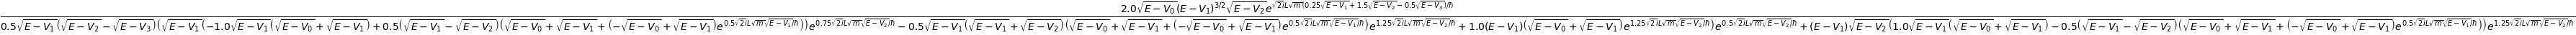

In [65]:
T_coeff = nonsimp_soln[2*n -2].simplify()
T_coeff